## MPAA rating prediction

In [49]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: using the rotten tomatoes dataset

In [50]:
dataset_df = pd.read_csv( './rtt_dataset/all_movie.csv' )
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Mummy: Tomb of the Dragon Emperor,PG-13,The Fast and the Furious director Rob Cohen co...
1,The Masked Saint,PG-13,The journey of a professional wrestler who bec...
2,Spy Hard,PG-13,"Dead pan Leslie Nielsen stars as Dick Steele, ..."
3,Der Baader Meinhof Komplex (The Baader Meinhof...,R,Director Uli Edel teams with screenwriter Bern...


In [51]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13 ', 'PG-13', 'R ', 'NR', 'PG', 'G', 'PG ', 'R', 'G ', 'NR ',
       'NC17', 'NC17 '], dtype=object)

In [52]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'R', 'NR', 'PG', 'G', 'NC17'], dtype=object)

In [53]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

In [54]:
pickle.dump(dataset_df, open('./data/dataset_df_cleaned_n_sample.pkl', 'wb'))

## Data Distribution

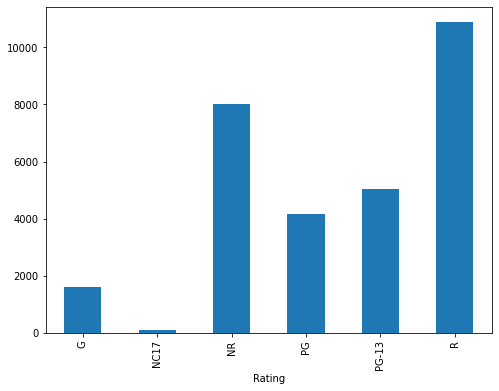

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [56]:
## drop G, NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC17'] 
dataset_df = dataset_df[dataset_df.Rating != 'G'] 

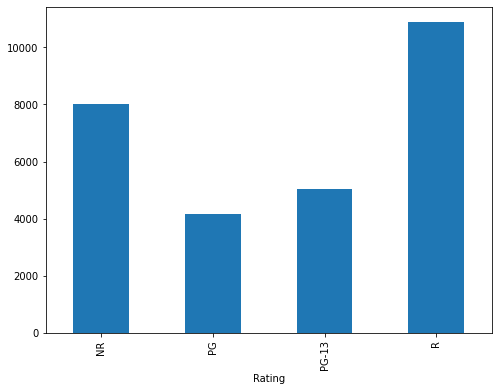

In [57]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [58]:
PG_count = dataset_df[dataset_df.Rating == 'PG'].shape
PG_count

(4172, 3)

In [59]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(4172)
dataset_df

,Title,Rating,Description
5801,Billy Jack Goes to Washington,PG,The fourth film starring Tom Laughlin as Billy...
23621,Scream 4,R,In Scream Sidney Prescott now the author of se...
3543,Wizards,PG,In this animated futuristic tale pair of twins...
9338,The Big Day (Jour De Fete),NR,In Jacques Tati charming and essentially plotl...
6532,The Mummy's Hand,NR,The first of four loose sequels to the origina...
...,...,...,...
7230,To Catch a Thief,PG,A jewel thief is at large on the Riviera and a...
595,Thunderball,PG,Thunderball finds James Bond matching wits wit...
28151,The Last Tycoon,PG,Based on an unfinished novel by Scott Fitzgera...
23078,Muppets Most Wanted,PG,Disney Muppets Most Wanted takes the entire Mu...


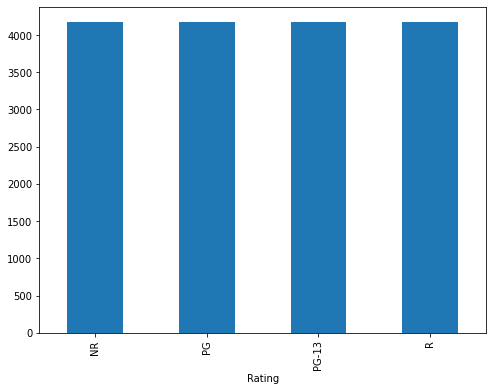

In [60]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Training model

In [61]:
training_df = pickle.load( open('./data/dataset_df_cleaned_n_sample.pkl', 'rb') )

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

In [63]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([4, 4, 4, ..., 5, 4, 4])

In [64]:
X = training_df['Description']
X

0        The Fast and the Furious director Rob Cohen co...
1        The journey of professional wrestler who becom...
2        Dead pan Leslie Nielsen stars as Dick Steele a...
3        Director Uli Edel teams with screenwriter Bern...
4        One of cluster of late films about the Vietnam...
                               ...                        
29805    Filmed at least nine times over the last nine ...
29806    Fred MacMurray stars in this Walt Disney comed...
29807    A resident of rd century Earth becomes involve...
29808    Supernova chronicles the search and rescue pat...
29809    For years there have been documented cases of ...
Name: Description, Length: 29810, dtype: object

## Train, test split

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [66]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [67]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [68]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [69]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [70]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [71]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [72]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [73]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         5635900   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 5,753,922
Trainable params: 118,022
Non-trainable params: 5,635,900
_________________________________________________________________


In [74]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_split=0.30, verbose=1)

Epoch 1/40
115/115 [==============================] - 76s 642ms/step - loss: 1.4920 - accuracy: 0.3615 - val_loss: 1.4305 - val_accuracy: 0.3971
Epoch 2/40
115/115 [==============================] - 74s 641ms/step - loss: 1.3835 - accuracy: 0.4085 - val_loss: 1.3215 - val_accuracy: 0.4344
Epoch 3/40
115/115 [==============================] - 72s 630ms/step - loss: 1.3201 - accuracy: 0.4406 - val_loss: 1.3128 - val_accuracy: 0.4485
Epoch 4/40
115/115 [==============================] - 72s 630ms/step - loss: 1.2818 - accuracy: 0.4600 - val_loss: 1.2761 - val_accuracy: 0.4659
Epoch 5/40
115/115 [==============================] - 72s 630ms/step - loss: 1.2419 - accuracy: 0.4852 - val_loss: 1.2155 - val_accuracy: 0.4871
Epoch 6/40
115/115 [==============================] - 71s 614ms/step - loss: 1.2107 - accuracy: 0.5002 - val_loss: 1.1861 - val_accuracy: 0.5071
Epoch 7/40
115/115 [==============================] - 69s 605ms/step - loss: 1.1605 - accuracy: 0.5181 - val_loss: 1.2044 - val_ac

In [75]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

280/280 [==============================] - 15s 54ms/step - loss: 1.0078 - accuracy: 0.7178
loss:  1.0077930688858032
accuracy:  0.7177680730819702


## Save model and tokenizer

In [76]:
# save model
model.save('./data/mpaa_classifier_n_sample.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_n_sample.pkl', 'wb'))

## Metrics

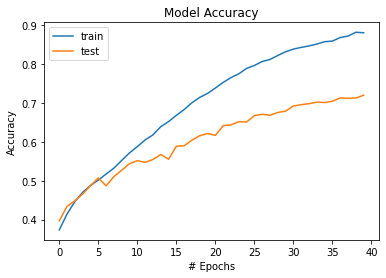

In [77]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

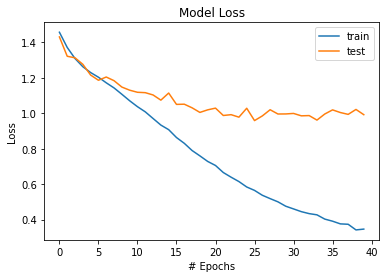

In [78]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()